# ppsim Python package

The `ppsim` package is used for simulating population protocols. The package and further example notebooks can be found on [Github](https://github.com/UC-Davis-molecular-computing/ppsim).

The core of the simulator uses a [batching algorithm](https://arxiv.org/abs/2005.03584) which gives significant asymptotic gains for protocols with relatively small reachable state sets. The package is designed to be run in a Python notebook, to concisely describe complex protocols, efficiently simulate their dynamics, and provide helpful visualization of the simulation.

## Installation

The package can be installed with `pip` via

In [ ]:
pip install ppsim

The most important part of the package is the `Simulation` class, which is responsible for parsing a protocol, performing the simulation, and giving data about the simulation.

In [1]:
from ppsim import Simulation

## Example protocol

A state can be any hashable Python object. The simplest way to describe a protocol is a dictionary mapping pairs of input states to pairs of output states.
For example, here is a description of the classic 3-state [approximate majority protocol](http://www.cs.yale.edu/homes/aspnes/papers/approximate-majority-journal.pdf). There are two initial states `A` and `B`, and the protocol converges with high probability to the majority state with the help of a third "undecided" state `U`.

In [2]:
a, b, u = 'A', 'B', 'U'
approximate_majority = {
    (a,b): (u,u),
    (a,u): (a,a),
    (b,u): (b,b)
}

## Example Simulation

To instantiate a `Simulation`, we must specify a protocol along with an initial condition, which is a dictionary mapping states to counts. Let's simulate approximate majority with in a population of one billion agents with a slight majority of `A` agents.

In [3]:
n = 10 ** 9
init_config = {a: 0.501 * n, b: 0.499 * n}
sim = Simulation(init_config, approximate_majority)

Now let's run this simulation for `10` units of parallel time (`10 * n` interactions). We will record the configuration every `0.1` units of time.

In [4]:
sim.run(10, 0.1)

 Time: 10.000


The `Simulation` class can display all these configurations in a `pandas` dataframe in the attribute `history`.

In [5]:
sim.history

,A,B,U
time (n interactions),,,
0.0,501000000,499000000,0
0.1,459457762,457439751,83102487
0.2,430276789,428217565,141505646
0.3,409027376,406898254,184074370
0.4,393162729,390949934,215887337
...,...,...,...
9.7,771074143,55357812,173568045
9.8,789103074,48973925,161923001
9.9,806667929,43076383,150255688


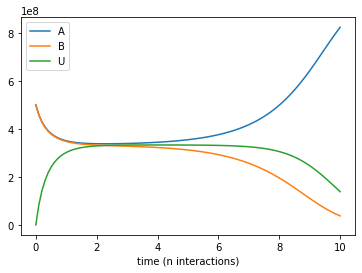

In [6]:
p = sim.history.plot()

Without specifying an end time, `run` will run the simulation until the configuration is silent (all interactions are null). In this case, that will be when the protocol reaches a silent majority consensus configuration.

 Time: 21.000


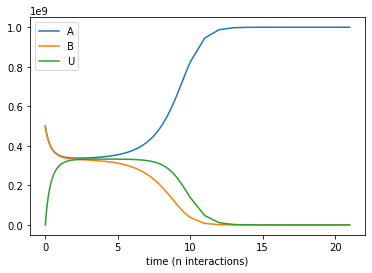

In [7]:
sim.run()
p = sim.history.plot()

Note that by default, `Simulation` assumes that input pair `(b,a)` will have the same transition as `(a,b)`, so order doesn't matter, with the default setting `transition_order = 'symmetric'`.
Thus we have the exact same protocol as if we had spent more time explicitly specifying

In [8]:
approximate_majority_symmetric = {
    (a,b): (u,u), (b,a): (u,u),
    (a,u): (a,a), (u,a): (a,a),
    (b,u): (b,b), (u,b): (b,b)
}

If we intentionally meant for these pairwise transitions to only happen in this specified order, we can declare that. We see in this case that it has the same behavior, but just runs twice as slow because now every interaction must happen in a specified order.

A, B  -->  U, U      with probability 0.5
A, U  -->  A, A      with probability 0.5
B, U  -->  B, B      with probability 0.5
 Time: 44.000


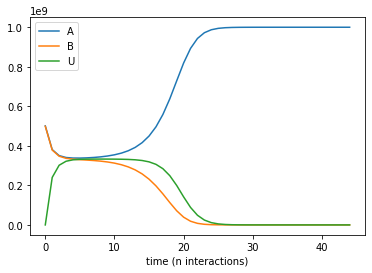

In [9]:
sim = Simulation(init_config, approximate_majority, transition_order='asymmetric')
print(sim.reactions)
sim.run()
p = sim.history.plot()

A key result about this protocol is it converges in expected O(log n) time, which surprisingly is very nontrivial to prove. We can use this package to very quickly gather some convincing data that the convergence really is O(log n) time, with the function `time_trials`.

In [10]:
from ppsim import time_trials
import numpy as np

ns = [int(n) for n in np.geomspace(10, 10 ** 8, 20)]
def initial_condition(n):
    return {'A': n // 2, 'B': n // 2}
df = time_trials(approximate_majority, ns, initial_condition, num_trials=100, max_wallclock_time = 30)
df

  0%|          | 0/20 [00:00<?, ?it/s]

,n,time
0,10,3.0
1,10,2.1
2,10,2.8
3,10,2.7
4,10,3.8
...,...,...
1492,42813323,23.8
1493,100000000,28.1
1494,100000000,25.2
1495,100000000,25.1


This dataframe collected time from up to 100 trials for each population size n across a many orders of magnitude, limited by the budget of 30 seconds of wallclock time that we gave it.
We can now use the `seaborn` library to get a convincing plot of the data.

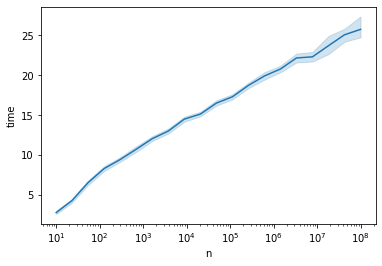

In [11]:
import seaborn as sns
lp = sns.lineplot(x='n', y='time', data=df)
lp.set_xscale('log')

## Larger state protocol

For more complicated protocols, it would be very tedious to use this dictionary format. Instead we can give an arbitrary Python function which takes a pair of states as input (along with possible other protocol parameters) and returns a pair of states as output (or if we wanted a randomized transition, it would output a dictionary which maps pairs of states to probabilities).

As a quick example, let's take a look at the discrete averaging dynamics, as analyzed [here](https://arxiv.org/abs/1808.05389) and [here](https://hal-cnrs.archives-ouvertes.fr/hal-02473856/file/main_JAP.pdf), which have been a key subroutine used in counting and majority protocols.

In [12]:
from math import ceil, floor

def discrete_averaging(a, b):
    avg = (a + b) / 2
    return floor(avg), ceil(avg)

n = 10 ** 6
sim = Simulation({0: n // 2, 50: n // 2}, discrete_averaging)

We did not need to explicitly describe the state set. Upon initialization, `Simulation` used breadth first search to find all states reachable from the initial configuration.

In [13]:
print(sim.state_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


This enumeration will call the function `rule` we give it O(q^2) times, where q is the number of reachable states. This preprocessing step also builds an internal representation of the transition function, so it will not need to continue calling `rule`. Thus we don't need to worry too much about our code for `rule` being efficient.

Rather than the dictionary format used to input the configuration, internally `Simulation` represents the configuration as an array of counts, where the ordering of the indices is given by `state_list`.

In [14]:
sim.config_dict

{0: 500000, 50: 500000}

In [15]:
sim.config_array

array([500000,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0, 500000], dtype=int64)

A key result about these discrete averaging dynamics is that they converge in O(log n) time to at most 3 consecutive values. It could take longer to reach the ultimate silent configuration with only 2 consecutive values, so if we wanted to check for the faster convergence condition, we could use a function that checks for the condition. This function takes a configuration dictionary (mapping states to counts) as input and returns `True` if the convergence criterion has been met.

In [16]:
def three_consecutive_values(config):
    states = config.keys()
    return max(states) - min(states) <= 2

Now we can run until this condition is met (or also use `time_trials` as above to generate statistics about this convergence time).

In [17]:
sim.run(three_consecutive_values, 0.1)
sim.history

 Time: 14.300


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
time (n interactions),,,,,,,,,,,,,,,,,,,,,
0.0,500000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,500000
0.1,450122,1,1,16,2,0,364,127,0,18,...,23,0,116,344,4,1,15,1,1,450204
0.2,401218,11,18,242,48,17,2059,692,26,211,...,236,25,697,2053,22,37,180,2,3,401462
0.3,354315,40,63,696,147,72,5015,1722,151,759,...,706,97,1725,4952,76,163,717,43,32,354744
0.4,309976,109,135,1527,382,247,8439,2994,404,1714,...,1673,380,2934,8292,249,414,1588,140,108,310440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13.9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With a much larger number of states, the `history` dataframe is more unwieldly, so trying to directly call `history.plot()` would be very messy and not very useful.
Instead we will bring in a `Snapshot` object that makes a bar plot with the counts of each state, and lets us visualize the way the distribution evolves over time.

For this `StatePlotter` object to work as intended, we need to be using an interactive matplotlib backend, such as `%matplotlib widget` or `%matplotlib qt`. It is recommended to use `%matplotlib widget`, which uses the package [ipympl](https://github.com/matplotlib/ipympl), and to run the notebook with [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/).

Note these interactive plots are not displayed in a static notebook. Also note that some common IPython environments such as [Google Colab](https://colab.research.google.com/) do not support any of the interactive matplotlib backends, which prevents the interactive `Snapshot` objects `StatePlotter` and `HistoryPlotter` from working correctly.

In [18]:
# Requires ipympl package, can be installed from pip with pip install ipympl
%matplotlib widget

from ppsim import StatePlotter
sp = StatePlotter(update_time=1)
sim.add_snapshot(sp)
sim.snapshot_slider('time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='time', layout=Layout(width='100%'), max=14.299999999…

To better visualize small count states, let's change `yscale` to `symlog`.

In [19]:
sp.ax.set_yscale('symlog')

If we run the `Simulation` while this `Snapshot` has already been created, it will update while the simulation runs. Because the population average was exactly 25, the ultimate silent configuration will have every agent in state 50, but it will take a a very long time to reach, as we must wait for pairwise interactions between dwindling counts of states 24 and 26. We can check that this reaction is now the only possible non-null interaction.

In [20]:
print(sim.enabled_reactions)

24, 26  -->  25, 25


As a result, the probability of a non-null interaction will grow very small, upon which the simulator will switch to the Gillespie algorithm. This allows it to relatively quickly run all the way until silence, which we can confirm takes a very long amount of parallel time.

In [21]:
# In order to see a Snapshot update live while the simulation is running, the command sim.add_snapshot() must be called in a previous cell
# After the Snapshot is already displayed, calling sim.run() will update it in real time
# The parameter Snapshot.update_time controls how often (in seconds) the Snapshot will get updated

# Setting history_interval to be a function of time t that shrinks, to not record too many configurations over a long time scale
sim.run(history_interval=lambda t: 10 ** len(str(int(t))) / 100)

Since the timescale of the whole simulation is now very long, we should have the slider range across recorded indices rather than parallel time.

In [22]:
display(sp.fig.canvas)
sim.snapshot_slider('index')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='index', layout=Layout(width='100%'), max=562), Output())…

For more examples see https://github.com/UC-Davis-molecular-computing/population-protocols-python-package/tree/main/examples/